### Problem Set 7 <br/> Keertana V. Chidambaram

#### Problem 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import scipy.interpolate as si

In [2]:
data = pd.read_csv('data/strongdrink.txt')

In [3]:
data.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
#Solution 1.a.
y = data['cultivar']
x_vars = ['alco', 'malic', 'tot_phen', 'color_int']
X = data[x_vars]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

In [5]:
LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)
index = pd.DataFrame(['beta0', 'beta1', 'beta2', 'beta3', 'beta4'])
j1 = pd.DataFrame([LogReg.intercept_[0]] + list(LogReg.coef_[0]))
j2 = pd.DataFrame([LogReg.intercept_[1]] + list(LogReg.coef_[1]))
result = pd.concat([index, j1, j2], axis=1)
result.columns = ['coefficient','j = 1','j = 2']
result

,coefficient,j = 1,j = 2
0,beta0,-24.010989,22.802446
1,beta1,1.700403,-1.468044
2,beta2,-0.265605,-0.333053
3,beta3,1.223894,0.664012
4,beta4,0.022756,-0.922712


In [6]:
y_pred=LogReg.predict(X_test)
target_names = ['j=1', 'j=2', 'j=3']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         j=1       0.87      1.00      0.93        13
         j=2       1.00      0.90      0.95        21
         j=3       1.00      1.00      1.00        10

   micro avg       0.95      0.95      0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [7]:
error_rates = pd.DataFrame([1 - 0.87, 0, 0])
error_rates.index = target_names
error_rates.columns = ['error rate']
error_rates

,error rate
j=1,0.13
j=2,0.00
j=3,0.00


j=2,3 are the categories with the lowest error rates. But j=3 has the best f1 score. So j=3 has best prediction according to this model.

In [8]:
data['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

j=2 has the  most number of observations but it is not the best predicted group in this model.

In [9]:
print('Test set MSE = ', mean_squared_error(y_test, y_pred))

Test set MSE =  0.045454545454545456


In [10]:
#Solution 1.b.

In [11]:
Xvars = X.values
yvars = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
y_pred = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)
    y_pred[test_index] = LogReg.predict(X_test)
    
    MSE_vec[test_index] = y_test != y_pred[test_index]

MSE_loo = MSE_vec.mean()
print('test estimate MSE loocv=', MSE_loo)

test estimate MSE loocv= 0.07954545454545454


In [12]:
print(classification_report(yvars, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.93      0.92        59
           2       0.91      0.90      0.91        71
           3       0.96      0.93      0.95        46

   micro avg       0.92      0.92      0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



In [13]:
error_rates = pd.DataFrame([1 - 0.90, 1 - 0.91, 1 - 0.96])
error_rates.index = target_names
error_rates.columns = ['error rate']
error_rates

,error rate
j=1,0.10
j=2,0.09
j=3,0.04


Clearly, the error rates for all 3 categories have increased as compared to part a.

In [14]:
#Solution 1.c.

In [15]:
Xvars = X.values
yvars = y.values
k = 4
kf = KFold(n_splits=4, shuffle=True, random_state=10)
kf.get_n_splits(Xvars)

MSE_vec_kf = np.zeros(k)
y_pred = np.zeros(len(yvars))

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = LogisticRegression(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)
    
    y_pred[test_index] = LogReg.predict(X_test)

    err = y_pred[test_index] != y_test
    MSE_vec_kf[k_ind] = err.mean()
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
print('test estimate MSE k-fold (k=4) =', MSE_kf)

test estimate MSE k-fold (k=4) = 0.09090909090909091


In [16]:
print(classification_report(yvars, y_pred))

              precision    recall  f1-score   support

           1       0.87      0.93      0.90        59
           2       0.91      0.87      0.89        71
           3       0.96      0.93      0.95        46

   micro avg       0.91      0.91      0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



In [17]:
error_rates = pd.DataFrame([1 - 0.87, 1 - 0.91, 1 - 0.96])
error_rates.index = target_names
error_rates.columns = ['error rate']
error_rates

,error rate
j=1,0.13
j=2,0.09
j=3,0.04


The error rates are the same for j = 2,3 but it has increased for j=1.

#### Problem 2

In [18]:
data = pd.read_csv('data/CoolIndex.txt', names = ['age', 'coolness'])

In [19]:
data.head()

,age,coolness
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


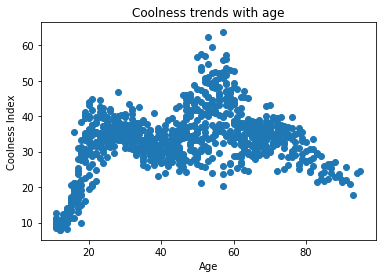

In [20]:
#Solution 2.a.
X = data['age']
y = data['coolness']
plt.scatter(X, y)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness trends with age')
plt.show()

In [21]:
#Solution 2.b.

In [22]:
data['bin1'] = 1
data['bin1'] = data['bin1'].where((data.age >= 11) & (data.age < 22), 0)
data['bin2'] = 1
data['bin2'] = data['bin2'].where((data.age >= 22) & (data.age < 40), 0)
data['bin3'] = 1
data['bin3'] = data['bin3'].where((data.age >= 40) & (data.age < 59), 0)
data['bin4'] = 1
data['bin4'] = data['bin4'].where((data.age >= 59) & (data.age < 77), 0)
data['bin5'] = 1
data['bin5'] = data['bin5'].where((data.age >= 77) & (data.age <= 95), 0)

In [23]:
xvars = ['bin1', 'bin2','bin3','bin4','bin5']
X = data[xvars]
y = data['coolness']
result = sm.OLS(y, X).fit()

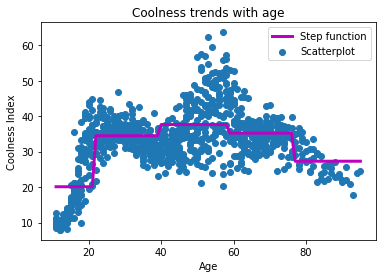

In [24]:
X = data['age']
y = data['coolness']
plt.scatter(X, y, label='Scatterplot')
plt.plot(X, result.predict(), color = 'm', label = "Step function", linewidth=3.0)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness trends with age')
plt.legend()
plt.show()

In [25]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 27 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        01:28:08   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          20.1025      0.562     35.746      0.000      18.999      21.206
bin2          34.4758      0.431     80.006      0.000      33.630      35.321
bin3          37.6351      0.424     88.814      0.000      36.804      38.467
bin4          35.2254      0.485     72.560      0.000      34.273      36.178
bin5          27.2964      0.936     29.175      0.000      25.460      29.132
==============================================================================
Omnibus:                       80.102   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.718
Skew:                           0.714   Prob(JB):                     8.17e-23
Kurtosis:                       3.719   Cond. No.                         2.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Coefficients for bin 1 to 5 correspond to the estimated value for beta 1 to 5 respectively. A 73 year old belongs in bin 4, thus predicted value = $35.2254$, alternatively we can also show:

In [26]:
result.predict([0, 0, 0, 1, 0])

array([35.22540004])

In [27]:
#Solution 2.c.

In [28]:
data2 = data.groupby('age').mean()
data2['age'] = data2.index
knots = [22, 40, 59, 77]
spl_lin_cool = si.LSQUnivariateSpline(np.array(data2['age']), np.array(data2['coolness']), t=knots, k=1)

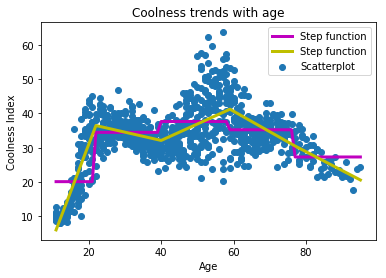

In [29]:
X = data['age']
y = data['coolness']
X2 = data2['age']
plt.scatter(X, y, label='Scatterplot')
plt.plot(X, result.predict(), color = 'm', label = "Step function", linewidth=3.0)
plt.plot(X2, spl_lin_cool(X2), color = 'y', label = "Step function", linewidth=3.0)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness trends with age')
plt.legend()
plt.show()

Predicted coolness of a 73 year-old:

In [30]:
spl_lin_cool(73)

array(32.86784862)

In [31]:
#Solution 2.d.

In [32]:
data2 = data.groupby('age').mean()
data2['age'] = data2.index
knots = [22, 40, 59, 77]
spl_cub_cool = si.LSQUnivariateSpline(np.array(data2['age']), np.array(data2['coolness']), t=knots, k=3)

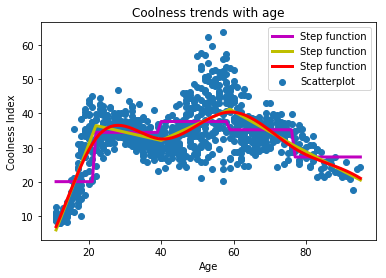

In [33]:
X = data['age']
y = data['coolness']
X2 = data2['age']
plt.scatter(X, y, label='Scatterplot')
plt.plot(X, result.predict(), color = 'm', label = "Step function", linewidth=3.0)
plt.plot(X2, spl_lin_cool(X2), color = 'y', label = "Step function", linewidth=3.0)
plt.plot(X2, spl_cub_cool(X2), color = 'r', label = "Step function", linewidth=3.0)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness trends with age')
plt.legend()
plt.show()

Predicted coolness of a 73 year-old:

In [34]:
spl_cub_cool(73)

array(32.64230107)